In [1]:
from pytorch_widedeep.preprocessing import TabPreprocessor, WidePreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Dispositivo atual: {device}')

Dispositivo atual: cuda


In [3]:
train_csv = pd.read_csv('playground_data/train_balanced.csv')

In [4]:
train_csv.head(5)

,Unnamed: 0.1,Unnamed: 0,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,num_reported_accidents,accident_risk,classification
0,0,0,urban,2,0.06,35,daylight,rainy,False,True,1,0.13,tranquila
1,1,1,urban,4,0.99,35,daylight,clear,True,False,0,0.35,media
2,4,4,rural,1,0.58,60,daylight,foggy,False,False,1,0.56,media
3,5,5,highway,3,0.54,70,night,foggy,True,False,0,0.61,media
4,6,6,highway,1,0.04,45,night,foggy,False,True,2,0.20,tranquila


In [5]:
train_csv = train_csv.drop(['Unnamed: 0','Unnamed: 0.1','classification'],axis=1)

In [6]:
train_csv = pd.read_csv('playground_data/train_balanced.csv')
train_csv = train_csv.drop(['Unnamed: 0','Unnamed: 0.1','classification'],axis=1)
train_csv = train_csv.sample(frac=0.01, random_state=42)
print(train_csv.head(5))

       road_type  num_lanes  curvature  speed_limit lighting weather  \
207304     urban          1       0.76           35    night   foggy   
291393     urban          3       0.58           45    night   rainy   
304968     urban          2       0.37           25    night   rainy   
224364     rural          2       0.96           45      dim   foggy   
184404     urban          1       0.49           25    night   clear   

        road_signs_present  public_road  num_reported_accidents  accident_risk  
207304                True        False                       1           0.49  
291393                True         True                       2           0.48  
304968                True        False                       1           0.38  
224364                True         True                       0           0.47  
184404               False         True                       1           0.39  


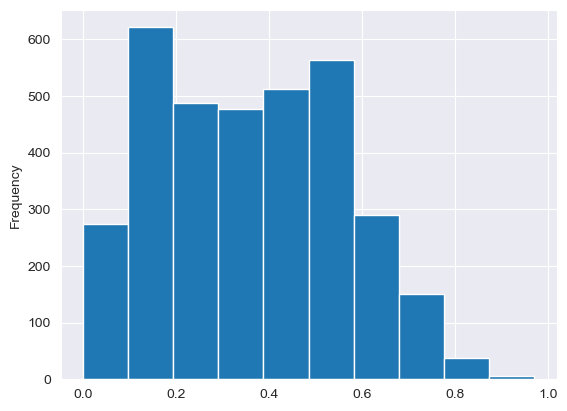

In [7]:
_ = train_csv['accident_risk'].plot(kind='hist')
plt.show()

In [8]:
# Tabular
tab_preprocessor = TabPreprocessor(
    embed_cols=['road_type','lighting','weather','road_signs_present','public_road','speed_limit'],
    continuous_cols=['num_lanes','curvature','num_reported_accidents'],
)


In [9]:
X_tab = tab_preprocessor.fit_transform(train_csv)

C:\Users\leala\anaconda3\Lib\site-packages\pytorch_widedeep\preprocessing\tab_preprocessor.py:364: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


In [35]:

tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=tab_preprocessor.continuous_cols,
    mlp_hidden_dims=[128  ,32,4,1],
    #cont_norm_layer = 'layernorm',
    #cont_embed_activation = 'relu',
)

In [36]:
train_tensor = torch.utils.data.TensorDataset(torch.tensor(X_tab, dtype=torch.float32),
                                              torch.tensor(train_csv["accident_risk"].values, dtype=torch.float32)
                                              )
#test_tensor = torch.utils.data.TensorDataset(torch.tensor(test_embs, dtype=torch.float32),
#                                             torch.tensor(test_labels, dtype=torch.float32)
#                                             )

train_loader = DataLoader(train_tensor, batch_size=128
                          #, shuffle=True
                          )
#test_loader = DataLoader(test_tensor, batch_size=64)

In [37]:
model_mlp = tab_mlp.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

for epoch in range(100):
    model_mlp.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model_mlp(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss {total_loss/len(train_loader):.4f}")

C:\Users\leala\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\leala\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([91])) that is different to the input size (torch.Size([91, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Loss 0.0775
Epoch 2: Loss 0.0595
Epoch 3: Loss 0.0578
Epoch 4: Loss 0.0552
Epoch 5: Loss 0.0523
Epoch 6: Loss 0.0521
Epoch 7: Loss 0.0511
Epoch 8: Loss 0.0513
Epoch 9: Loss 0.0514
Epoch 10: Loss 0.0507
Epoch 11: Loss 0.0507
Epoch 12: Loss 0.0506
Epoch 13: Loss 0.0518
Epoch 14: Loss 0.0497
Epoch 15: Loss 0.0511
Epoch 16: Loss 0.0513
Epoch 17: Loss 0.0499
Epoch 18: Loss 0.0522
Epoch 19: Loss 0.0526
Epoch 20: Loss 0.0515
Epoch 21: Loss 0.0511
Epoch 22: Loss 0.0512
Epoch 23: Loss 0.0518
Epoch 24: Loss 0.0524
Epoch 25: Loss 0.0507
Epoch 26: Loss 0.0514
Epoch 27: Loss 0.0512
Epoch 28: Loss 0.0515
Epoch 29: Loss 0.0503
Epoch 30: Loss 0.0503
Epoch 31: Loss 0.0521
Epoch 32: Loss 0.0504
Epoch 33: Loss 0.0517
Epoch 34: Loss 0.0502
Epoch 35: Loss 0.0504
Epoch 36: Loss 0.0499
Epoch 37: Loss 0.0508
Epoch 38: Loss 0.0518
Epoch 39: Loss 0.0512
Epoch 40: Loss 0.0503
Epoch 41: Loss 0.0511
Epoch 42: Loss 0.0521
Epoch 43: Loss 0.0506
Epoch 44: Loss 0.0514
Epoch 45: Loss 0.0521
Epoch 46: Loss 0.05

Mean Absolute Error: 0.3625241287627932
Mean Squared Error: 0.16952216901097283
Root Mean Squared Error: 0.4117306996216979
R^2 Score: -3.4495846921208537


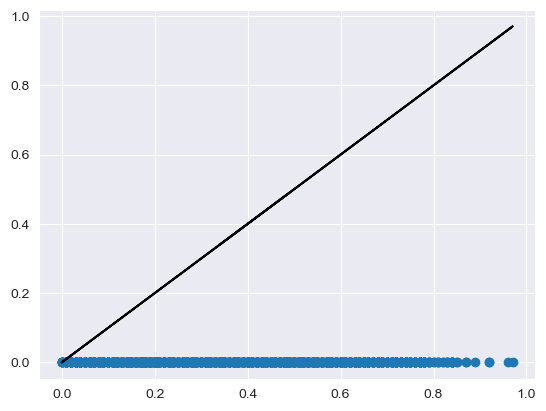

In [34]:


model_mlp.eval()
preds, trues = [], []
with torch.no_grad():
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        out = model_mlp(X)
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        trues.extend(y.cpu().numpy())

mae = mean_absolute_error(trues, preds)
mse = mean_squared_error(trues, preds)
rmse = np.sqrt(mse)
r2 = r2_score(trues, preds)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

plt.scatter(trues, preds)
plt.plot(trues, trues, 'k')
plt.show()